## Register datasets

In [1]:
from detectron2.data.datasets import register_coco_instances
# Some configurations
name_ds = "real3"
name_ds_train = name_ds + "_train"
name_ds_test = name_ds + "_test"
image_root_train = "../../ufsc_dataset/real3/data/output_resized/train/images"
image_root_test = "../../ufsc_dataset/real3/data/output_resized/val/images"
# af = "_annotations.coco.json"
json_file_train = image_root_train + "/../../_train_resized.json"
json_file_test = image_root_test + "/../../_test_resized.json"

from detectron2.data import MetadataCatalog
MetadataCatalog.get(name_ds_train).thing_classes = ["Crack", "ExposedRebars"]
MetadataCatalog.get(name_ds_test).thing_classes = ["Crack", "ExposedRebars"]
MetadataCatalog.get(name_ds_train).thing_colors =[(255,0,0),(0,255,0)]
MetadataCatalog.get(name_ds_test).thing_colors =[(255,0,0),(0,255,0)]  
# Register datasets
## train dataset
register_coco_instances(
    name = name_ds_train,
    metadata = {},
    json_file = json_file_train,
    image_root = image_root_train
    )
## test dataset
register_coco_instances(
    name = name_ds_test,
    metadata = {},
    json_file = json_file_test,
    image_root = image_root_test
    )





In [2]:
import json
import os
def count_data(json_path):
    # folder = "/mnt/d/deepLearning/ufsc_dataset/real3/images"
    # for labels in ["_train.json", "_test.json"]:
    # p = os.path.join(folder, labels)
    with open(json_path, 'r') as file:  
        coco_data = json.load(file)
        image_counts = {}
        annotation_counts = {}
        for annotation in coco_data['annotations']:
            category_id = annotation['category_id']
            if category_id in annotation_counts:
                annotation_counts[category_id] += 1
            else:
                annotation_counts[category_id] = 1
        for image in coco_data['images']:
            id = image['id']
            if id in image_counts:
                image_counts[id] += 1
            else:
                image_counts[id] = 1
    # print(f"Images {labels}: {len(image_counts)}")
    # print(f"Category(ies): {sorted(annotation_counts.items())}")    
    return (len(image_counts), sorted(annotation_counts.items()))
train_data, train_caregoties = count_data(json_file_train)
print(f"Images: {train_data} total \nCategory(ies):{train_caregoties}")

Images: 2140 total 
Category(ies):[(1, 2889), (2, 1648)]


In [3]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer, ColorMode
import random
# random.seed(42)
import cv2
import matplotlib.pyplot as plt

def plot_random_samples(name_ds, n=3):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  # plot (arrange in 3x3)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
  for i,s in enumerate(random.sample(ds, n)):
    ax = axs[i//ncols][i%ncols] if len(axs.shape) == 2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
    v = v.draw_dataset_dict(s)
    ax.imshow(v.get_image())
    ax.axis("off")
  # plt.tight_layout()
  # plt.show()

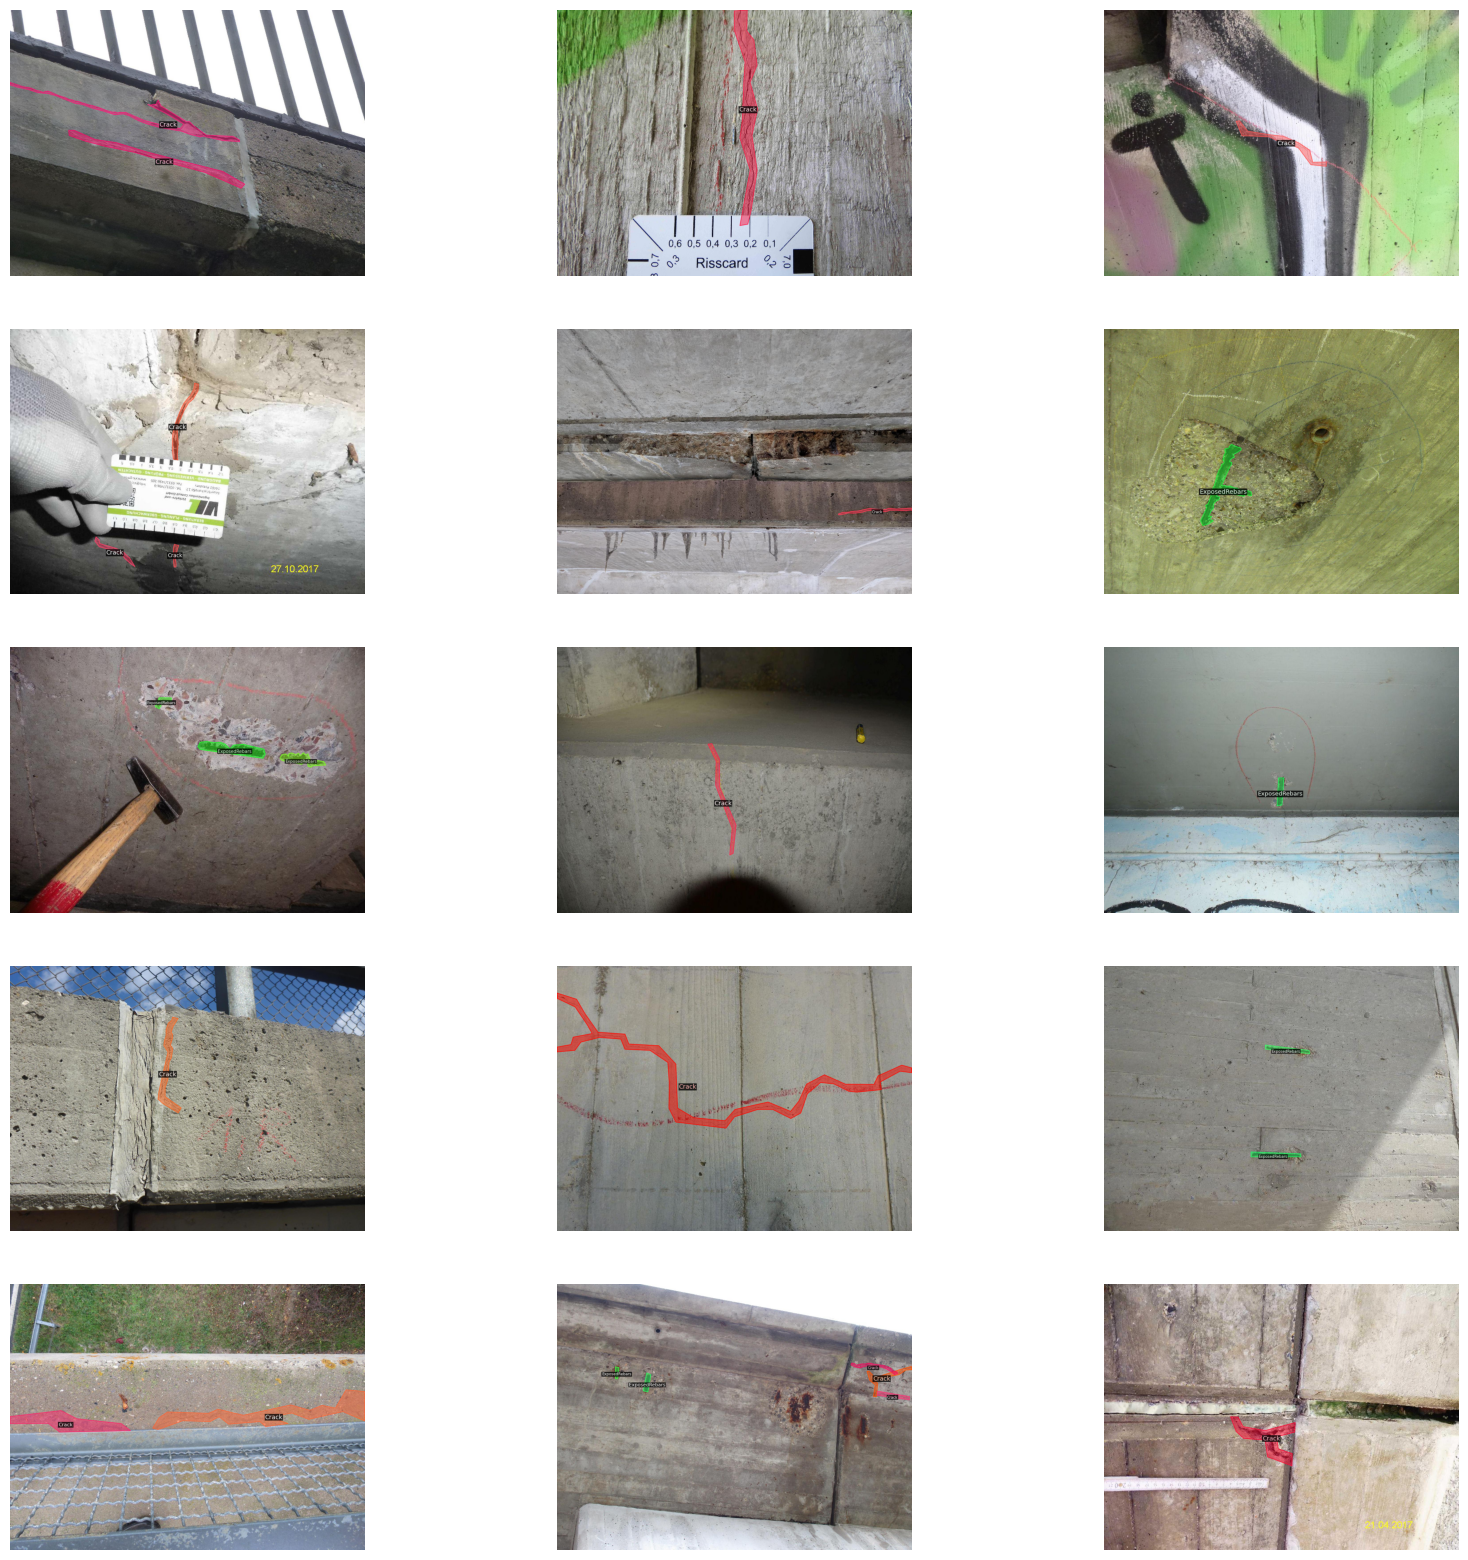

In [14]:
plot_random_samples(name_ds_train, n = 15)                                                               

## Net configuration

In [5]:
import os
import torch
from detectron2.config import get_cfg
from detectron2 import model_zoo
import pickle
#log training/inferencing information:
from detectron2.utils.logger import setup_logger                                                    
logger = setup_logger()             

output_dir = "output/detectron2_ufsc"
os.makedirs(output_dir, exist_ok=True)
output_cfg_path = os.path.join(output_dir, "cfg.pickle")
#number of classes
nc = 2                                                                                              
device = "cuda" #if torch.cuda.is_available() else "cpu"
# Select a model
config_file_url = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"

In [6]:
# Create a configuration file
cfg = get_cfg()
config_file = model_zoo.get_config_file(config_file_url)
cfg.merge_from_file(config_file)
# Download weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(checkpoint_url)
# Set datasets
cfg.DATASETS.TRAIN = (name_ds_train,)
cfg.DATASETS.TEST = (name_ds_test,)
# Workers
cfg.DATALOADER.NUM_WORKERS = 8  #related to GPU
# Images per batch
cfg.SOLVER.IMS_PER_BATCH = 1    #related to GPU
# Iterations
int_p_epoch = int(train_data/cfg.SOLVER.IMS_PER_BATCH)
max_iteration = 200 * int_p_epoch
cfg.SOLVER.MAX_ITER = max_iteration      #not counted as epochs but as batches
print("Iteration per epoch:",int_p_epoch,
      "\nMax. iteration: ", cfg.SOLVER.MAX_ITER,
      "\nCorrepond to:", int(max_iteration/int_p_epoch),"epochs.")
cfg.SOLVER.WARMUP_ITERS = .5 * int_p_epoch
# cfg.SOLVER.STEPS = (3 * int_p_epoch,
#                     5 * int_p_epoch)
# cfg.SOLVER.GAMMA = 0.1
# Hyperparameters
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.NESTROV = False
# checkpoint
cfg.SOLVER.CHECKPOINT_PERIOD = int(int_p_epoch/2)
# anchors
# cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[ 72.03739609,  19.8642677,  130.32616632,  41.30086179, 265.67806371]] #[e_sizes]            
# cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[3.64624881, 0.23890966, 1.02422127]] #[e_ratios]   
# pixels
cfg.MODEL.PIXEL_MEAN = [124.8775, 133.0573, 136.6406] #rs.mean.tolist()
cfg.MODEL.PIXEL_STD = [54.7122, 51.9867, 52.0061]     #rs.mean.std()
# Evaluation
cfg.TEST.EVAL_PERIOD = cfg.SOLVER.CHECKPOINT_PERIOD
# Classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = nc
cfg.MODEL.DEVICE = device
cfg.OUTPUT_DIR = output_dir
#RPN
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 256  #256 
cfg.MODEL.RPN.POSITIVE_FRACTION = 0.5 #0.5 
cfg.MODEL.RPN.IOU_THRESHOLDS = [0.3, 0.7] #[0.3, 0.7] 
#ROI HEADS TRAIN
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512 #512 
cfg.MODEL.ROI_HEADS.IOU_THRESHOLDS = [0.6] #[0.5] 
cfg.MODEL.ROI_HEADS.POSITIVE_FRACTION = 0.25 #.25 
#ROI HEADS TEST
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5 #0.5 
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05 #.05 

# if median_width >= median_height:
#       max = median_width
#       min = median_height
# else:
#       max = median_height
#       min = median_width
cfg.INPUT.MAX_SIZE_TRAIN = int(640)
cfg.INPUT.MAX_SIZE_TEST = int(640)
cfg.INPUT.MIN_SIZE_TEST = int(640)
cfg.INPUT.MIN_SIZE_TRAIN = int(640,)
# target_width = int(1600)
# target_height = int(1200)



Iteration per epoch: 2140 
Max. iteration:  428000 
Correpond to: 200 epochs.
640
640
640
640
2
choice


In [7]:
# save configuration file for future use
with open(output_cfg_path, "wb") as f:
  pickle.dump(cfg, f, protocol = pickle.HIGHEST_PROTOCOL)

## Training

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper
from detectron2.data import build_detection_train_loader


class BrainTumorTrainer(DefaultTrainer):
  """
  This trainer evaluate data on the `cfg.DATASETS.TEST` validation dataset every `cfg.TEST.EVAL_PERIOD` iterations.
  """
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder == None:
      output_folder = cfg.OUTPUT_DIR
    else:
      output_folder = os.path.join(cfg.OUTPUT_DIR, output_folder)
      os.makedirs(output_folder)
    # Use 
    return COCOEvaluator(dataset_name, distributed=False, output_dir=output_folder)
  
  def build_train_loader(cls, cfg):
    augs = []
    # Aug 1: Add RandomBrightness with 50% chance
    augs.append(
        T.RandomApply(
          T.RandomBrightness(
              intensity_min = 0.5,
              intensity_max = 1.5),
          prob = 0.5
        ))
    # Aug 2: Add RandomContrast with 50% chance
    augs.append(
        T.RandomApply(
          T.RandomContrast(
              intensity_min = 0.5,
              intensity_max = 1.5),
          prob = 0.5
        ))    
    
    # Aug 3: Add RandomSaturation with 50% chance
    augs.append(
        T.RandomApply(
          T.RandomSaturation(
              intensity_min = 0.5,
              intensity_max = 1.5),
          prob = 0.5
        ))   
    # Aug 4: Add ResizeShortestEdge
    min_size = cfg.INPUT.MIN_SIZE_TRAIN
    max_size = cfg.INPUT.MAX_SIZE_TRAIN
    sample_style = cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
    augs.append(T.ResizeShortestEdge(
            min_size, 
            max_size, 
            sample_style)
        )

    # Aug 5: Add RandomFlipping
    if cfg.INPUT.RANDOM_FLIP != "none":
      augs.append(T.RandomFlip(
          horizontal=cfg.INPUT.RANDOM_FLIP == "horizontal",
          vertical=cfg.INPUT.RANDOM_FLIP == "vertical",
        )
      )
      
    
    mapper = DatasetMapper(cfg, 
                           is_train       = True, 
                           augmentations  = augs)
    return build_detection_train_loader(cfg, mapper=mapper)
  
  



In [9]:
from detectron2.engine.hooks import HookBase
import torch
import logging

class BestModelHook(HookBase):
  def __init__(self, cfg, 
               metric   = "segm/AP50", 
               min_max  = "max"):
    self._period = cfg.TEST.EVAL_PERIOD
    self.metric = metric
    self.min_max = min_max
    self.best_value = float("-inf") if min_max == "max" else float("inf")
    logger = logging.getLogger("detectron2")
    logger.setLevel(logging.DEBUG)
    logger.propagate = False
    self._logger = logger
        

  def _take_latest_metrics(self):
    with torch.no_grad():
      latest_metrics = self.trainer.storage.latest()
      return latest_metrics
      
  def after_step(self):
    next_iter = self.trainer.iter + 1
    is_final = next_iter == self.trainer.max_iter
    if is_final or (self._period > 0 and next_iter % self._period == 0):
      latest_metrics = self._take_latest_metrics()
      for (key, (value, iter)) in latest_metrics.items():
        if key == self.metric:
          if (self.min_max == "min" and value < self.best_value) or (self.min_max == "max" and value > self.best_value):
            self._logger.info("Updating best model at iteration {} with {} = {}".format(iter, self.metric, value))
            self.best_value = value
            self.trainer.checkpointer.save("model_best")
            

In [10]:
import gc
gc.collect()

42539

### TensorBoard

In [13]:
%reload_ext tensorboard
output_dir = "/mnt/d/deepLearning/DL_frameworks/detectron2/output"
%load_ext tensorboard
%tensorboard --logdir {output_dir}  --port 6002 #--host localhost 

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6002 (pid 1475), started 0:00:02 ago. (Use '!kill 1475' to kill it.)

In [14]:
trainer = BrainTumorTrainer(cfg)
bm_hook = BestModelHook(cfg, 
                        metric  = "segm/AP50", 
                        min_max = "max")
trainer.register_hooks(hooks=[bm_hook])
trainer.resume_or_load(resume=True)
trainer.train()

[11/28 12:20:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[11/28 12:20:02 d2.engine.train_loop]: Starting training from iteration 0


/home/rafic/.virtualenvs/detectron2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/28 12:20:07 d2.utils.events]:  eta: 1 day, 1:01:28  iter: 19  total_loss: 2.607  loss_cls: 1.001  loss_box_reg: 0.007267  loss_mask: 0.6911  loss_rpn_cls: 0.8763  loss_rpn_loc: 0.05169    time: 0.2015  last_time: 0.2151  data_time: 0.0150  last_data_time: 0.0019   lr: 1.8739e-05  max_mem: 2045M
[11/28 12:20:11 d2.utils.events]:  eta: 23:44:01  iter: 39  total_loss: 1.873  loss_cls: 0.4948  loss_box_reg: 0.0002818  loss_mask: 0.6725  loss_rpn_cls: 0.5545  loss_rpn_loc: 0.06594    time: 0.1967  last_time: 0.2086  data_time: 0.0014  last_data_time: 0.0015   lr: 3.7412e-05  max_mem: 2045M
[11/28 12:20:15 d2.utils.events]:  eta: 23:14:59  iter: 59  total_loss: 1.228  loss_cls: 0.2127  loss_box_reg: 0.004653  loss_mask: 0.6668  loss_rpn_cls: 0.2501  loss_rpn_loc: 0.05901    time: 0.1927  last_time: 0.1745  data_time: 0.0015  last_data_time: 0.0014   lr: 5.6085e-05  max_mem: 2045M
[11/28 12:20:18 d2.utils.events]:  eta: 23:17:32  iter: 79  total_loss: 0.9628  loss_cls: 0.1309  loss_box_re

## Inferencing

In [ ]:
import random
random.seed(42)
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import matplotlib.pyplot as plt

def plot_samples(samples, 
                 met        = {}, 
                 is_gt      = True, 
                 predictor  = None):
  n = len(samples)
  nrows = int(-(-n/3)) # ceil
  ncols = 3
  fig, axs = plt.subplots(nrows   = nrows, 
                          ncols   = ncols, 
                          figsize = (21, 7))
  for i,s in enumerate(samples):
    row = i//ncols
    col = i%ncols
    ax = axs[row][col] if len(axs.shape)==2 else axs[i]
    img = cv2.imread(s["file_name"])
    v = Visualizer(img[:,:, ::-1], metadata=met, scale=0.5, instance_mode=ColorMode.SEGMENTATION)
    if is_gt:
      # visualize ground-truths
      v = v.draw_dataset_dict(s)
    else:
      # predict
      outputs = predictor(img)
      # visualize prediction results
      instances = outputs["instances"].to("cpu")
      v = v.draw_instance_predictions(instances)

    ax.imshow(v.get_image())
    ax.axis("off")
  plt.tight_layout()
  plt.show()

def plot_random_samples(name_ds, n=3, predictor=None):
  # access
  ds = DatasetCatalog.get(name_ds)
  met = MetadataCatalog.get(name_ds)
  samples = random.sample(ds, n)
  # plot samples with ground-truths
  plot_samples(samples, met)
  # plot predictions
  plot_samples(samples, 
               met        = met, 
               predictor  = predictor, 
               is_gt      = False)

In [ ]:
predictor = DefaultPredictor(cfg) #defined in Net configuration section
plot_random_samples(name_ds_test, predictor = predictor)